# Results Exploration

In [1]:
import sys
sys.path.append('./../src/')

import os
import re
import ast
import utils
import ioutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from feature_selection import _feature_importance_permutation

from sklearn.metrics import roc_auc_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def prep_selector_labels(labels):
    
    outputs = []
    for label in labels:
        splitted = label.split('_')
        
        if 'var' in splitted:
            outputs.append('Variance Threshold')
        if 'mutual' in splitted:
            for num, item in enumerate(splitted):
                splitted[num] = item.capitalize()
            outputs.append((' ').join(splitted))
        if 'relieff' in splitted:
            for num, item in enumerate(splitted):
                splitted[num] = item[:-1].capitalize() + item[-1].capitalize()
            outputs.append(('').join(splitted))
        if 'logregl1' in splitted:
            outputs.append('{}:\n{}'.format('Permutation Importance', 'Logistic Regression L1'))
        if 'logregl2' in splitted:
            outputs.append('{}:\n{}'.format('Permutation Importance', 'Logistic Regression L2'))
        if 'rf' in splitted:
            outputs.append('{}:\n{}'.format('Permutation Importance', 'Random Forest'))
            
    return outputs

In [3]:
def prep_feature_names(labels, image_type='squareroot'):
    
    outputs = []
    for label in labels:
        if image_type in label:
        
            if 'firstorder' in label:
                modality, _, kind, name = label.split('_')
                outputs.append('{} {}:\n{}'.format(
                    modality.upper(), kind.capitalize(), name)
                )
            else:
                modality, _, kind, name = label.split('_')
                outputs.append('{} {}:\n{}'.format(modality.upper(), kind.upper(), name))
        # Clinical variables.
        else:
            if 'hpv_1' in label:
                outputs.append('Recieved HPV')
            if 'hpv_2' in label:
                outputs.append('Missing HPV information')
            if 'peak' in label:
                outputs.append('SUV Peak')
            if 'mtv' in label:
                outputs.append(label.upper())
            if 't_class_3' in label:
                outputs.append('T-class 3')
            if 'stage' in label:
                outputs.append('Stage {}'.format(label.split('_')[1]))
            if 'icd10_C32' in label:
                outputs.append('ICD-10: C32')
            if 'cisplatin_6' in label:
                outputs.append('Cisplatin: 6')
            if 'original' in label:
                _, kind, name = label.split('_') 
                outputs.append('{}: {}'.format(kind.capitalize(), name))
            if 'cisplatin' in label:
                outputs.append('Cisplatin {}'.format(label.split('_')[1]))
                
    return outputs

In [4]:
X = pd.read_csv(
    './../../data/fallback/data_to_analysis/data.csv', index_col=0
)
y_pfs = pd.read_csv(
    './../../data/fallback/data_to_analysis/target_pfs.csv', index_col=0
)
y_lrc = pd.read_csv(
    './../../data/fallback/data_to_analysis/target_lrc.csv', index_col=0
)

In [5]:
X.shape

(198, 87)

## PFS

In [6]:
pfs_results_raw = pd.read_csv(
    './../../data/fallback/results/results_pfs.csv', index_col=0
)
pfs_results_raw.head()

,experiment_id,model,selector,best_params,avg_test_score,avg_train_score,best_features,num_features
0,684,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.567981,0.567981,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,86
1,559,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.535718,0.535718,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,85
2,629,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.542366,0.542366,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,86
3,192,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.544179,0.544179,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,86
4,835,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.553236,0.553236,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,86


In [7]:
model_names = []

avg_pfs_results = np.zeros((6, 6), dtype=float)
std_pfs_results = np.zeros((6, 6), dtype=float)
for row_num, (model_name, model_grp) in enumerate(pfs_results_raw.groupby('model')):
    model_names.append(model_name)
    for col_num, (selector_name, selector_grp) in enumerate(model_grp.groupby('selector')):
        avg_pfs_results[row_num, col_num] = selector_grp['avg_test_score'].mean()
        std_pfs_results[row_num, col_num] = selector_grp['avg_test_score'].std()

In [8]:
selector_names = prep_selector_labels(pfs_results_raw.selector.unique())

In [ ]:
plt.figure(figsize=(11, 11))
axis = sns.heatmap(
    avg_pfs_results, 
    vmin=np.nanmin(avg_pfs_results), vmax=np.nanmax(avg_pfs_results),
    cmap=plt.cm.viridis, robust=True,
    annot=True, fmt = '.3f', square=1, linewidth=.5, cbar=True,
    cbar_kws={'shrink': 0.6},  
)
plt.ylabel('Estimator', fontsize=20)
plt.xlabel('Feature Selector', fontsize=20)
plt.xticks(
    range(np.size(selector_names)), selector_names, 
    rotation='45', fontsize=17, x='right', va='top', 
)
plt.yticks(
    range(np.size(model_names)), model_names, 
    rotation='45', fontsize=17, y=-0.5
)
for num, value in enumerate(axis.texts): 
    value.set_text('{} \n+/- {}'.format(
        value.get_text(), 
        np.round(std_pfs_results.ravel()[num], decimals=3),
        fontsize=16
    )
)
plt.tight_layout()   
plt.savefig(
    './../../data/fallback/figures/pfs_matrix.png', 
    transparent=True, dpi=400
)

## LRC

In [9]:
lrc_results_raw = pd.read_csv(
    './../../data/fallback/results/results_lrc.csv', index_col=0
)
lrc_results_raw.head()

,avg_test_score,avg_train_score,best_features,best_params,experiment_id,model,num_features,selector
0,0.520569,0.520569,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",684,AdaBoostClassifier,86,logregl1_permut_imp
1,0.533694,0.533694,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",559,AdaBoostClassifier,86,logregl1_permut_imp
2,0.537017,0.537017,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",629,AdaBoostClassifier,86,logregl1_permut_imp
3,0.545093,0.545093,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",192,AdaBoostClassifier,86,logregl1_permut_imp
4,0.534762,0.534762,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",835,AdaBoostClassifier,86,logregl1_permut_imp


In [10]:
model_names = []

avg_lrc_results = np.zeros((6, 6), dtype=float)
std_lrc_results = np.zeros((6, 6), dtype=float)
for row_num, (model_name, model_grp) in enumerate(lrc_results_raw.groupby('model')):
    model_names.append(model_name)
    for col_num, (selector_name, selector_grp) in enumerate(model_grp.groupby('selector')):
        avg_lrc_results[row_num, col_num] = selector_grp['avg_test_score'].mean()
        std_lrc_results[row_num, col_num] = selector_grp['avg_test_score'].std()

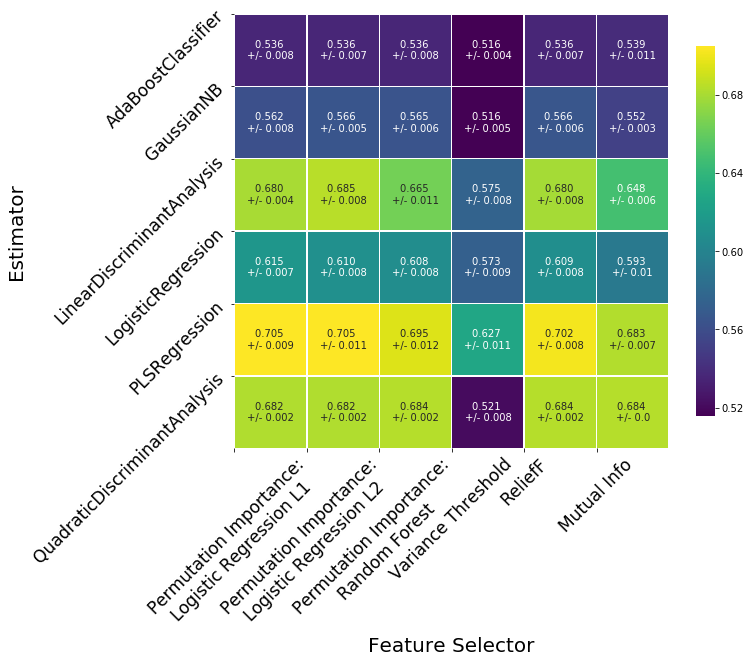

In [11]:
plt.figure(figsize=(11, 11))
axis = sns.heatmap(
    avg_lrc_results, 
    vmin=np.nanmin(avg_lrc_results), vmax=np.nanmax(avg_lrc_results),
    cmap=plt.cm.viridis, robust=True,
    annot=True, fmt = '.3f', square=1, linewidth=.5, cbar=True,
    cbar_kws={'shrink': 0.6},  
)
plt.ylabel('Estimator', fontsize=20)
plt.xlabel('Feature Selector', fontsize=20)
plt.xticks(
    range(np.size(selector_names)), selector_names, 
    rotation='45', fontsize=17, x='right', va='top', 
)
plt.yticks(
    range(np.size(model_names)), model_names, 
    rotation='45', fontsize=17, y=-0.5
)
for num, value in enumerate(axis.texts): 
    value.set_text('{} \n+/- {}'.format(
        value.get_text(), 
        np.round(std_lrc_results.ravel()[num], decimals=3),
        fontsize=16
    )
)
plt.tight_layout()   
plt.savefig(
    './../../data/fallback/figures/lrc_matrix.png', 
    transparent=True, dpi=400
)

## Feature analysis

In [12]:
def feature_consensus(df, num_feats=None):
    
    features = []
    votes = np.zeros(num_feats, dtype=int)
    for (model_name, model_data) in df.groupby('model'):
        if 'PLS' in model_name:
            for (sel_name, model_sel_data) in model_data.groupby('selector'):
                if 'logregl1' in sel_name:
                    for listing in model_sel_data['best_features'].values:
                        feature_set = [int(elem) for elem in re.findall(r'\d+', listing)]
                        features.append(feature_set)
                        votes[feature_set] += 1        

    return features, votes

In [13]:
pfs_features, pfs_votes = feature_consensus(pfs_results_raw, num_feats=X.columns.size)
lrc_features, lrc_votes = feature_consensus(lrc_results_raw, num_feats=X.columns.size)

In [14]:
pfs_votes[pfs_votes != 10] = 0
pfs_votes[pfs_votes == 10] = 1

In [15]:
lrc_votes[lrc_votes != 10] = 0
lrc_votes[lrc_votes == 10] = 1

In [16]:
sum(pfs_votes == 1), sum(lrc_votes == 1)

(84, 85)

In [17]:
np.size(pfs_votes), np.size(lrc_votes)

(87, 87)

In [18]:
model = PLSRegression(n_components=70, max_iter=500, scale=True, tol=0.001)

split = 160

X_pfs = X.loc[:, X.columns[pfs_votes == 1]]
_X, _y = X_pfs.values, np.squeeze(y_pfs.values)

X_train, y_train, = _X[:split, :], _y[:split]
X_test, y_test = _X[split:, :], _y[split:]

model.fit(X_train, y_train)

_, all_imps = _feature_importance_permutation(
    X_test, y_test, model,
    score_func=roc_auc_score, num_rounds=10, seed=0
)

In [21]:
# Output imp: ncols x nrouns
np.mean(all_imps, axis=1).shape

(84,)

In [27]:
def importance_ranking(X, y, model, seeds=10):
    
    importances = []
    for seed in range(seeds):
        
        sampler = utils.BootstrapOutOfBag(n_splits=50, random_state=seed)
        for train_idx, test_idx in sampler.split(X, y):
            
            X_train, X_test = X[train_idx, :], X[test_idx, :]
            y_train, y_test = y[train_idx], y[test_idx]
            X_train_std, X_test_std = utils.train_test_z_scores(X_train, X_test)
            
            model.fit(X_train_std, y_train)
            
            _, all_imps = _feature_importance_permutation(
                X_test_std, y_test, model, score_func=roc_auc_score, 
                num_rounds=10, seed=seed
            )
        importances.append(np.mean(all_imps, axis=1))
        
    return np.mean(importances, axis=0), np.std(importances, axis=0)

In [28]:
X_pfs = X.loc[:, X.columns[pfs_votes == 1]]
X_lrc = X.loc[:, X.columns[lrc_votes == 1]]

In [29]:
pfs_model = PLSRegression(n_components=70, max_iter=500, scale=True, tol=0.001)
avg_pfs_importances, std_pfs_importances = importance_ranking(
    X_pfs.values, np.squeeze(y_pfs.values), pfs_model
)

In [30]:
lrc_model = PLSRegression(n_components=70, max_iter=500, scale=True, tol=0.001)
avg_lrc_importances, std_lrc_importances = importance_ranking(
    X_lrc.values, np.squeeze(y_lrc.values), lrc_model
)

In [31]:
# Select top n features.
n_top = 5
pfs_top_idx = avg_pfs_importances.argsort()[-n_top:][::-1]
lrc_top_idx = avg_lrc_importances.argsort()[-n_top:][::-1]

pfs_avg_top = avg_pfs_importances[pfs_top_idx]
lrc_avg_top = avg_lrc_importances[lrc_top_idx]

pfs_std_top = std_pfs_importances[pfs_top_idx]
lrc_std_top = std_lrc_importances[lrc_top_idx]

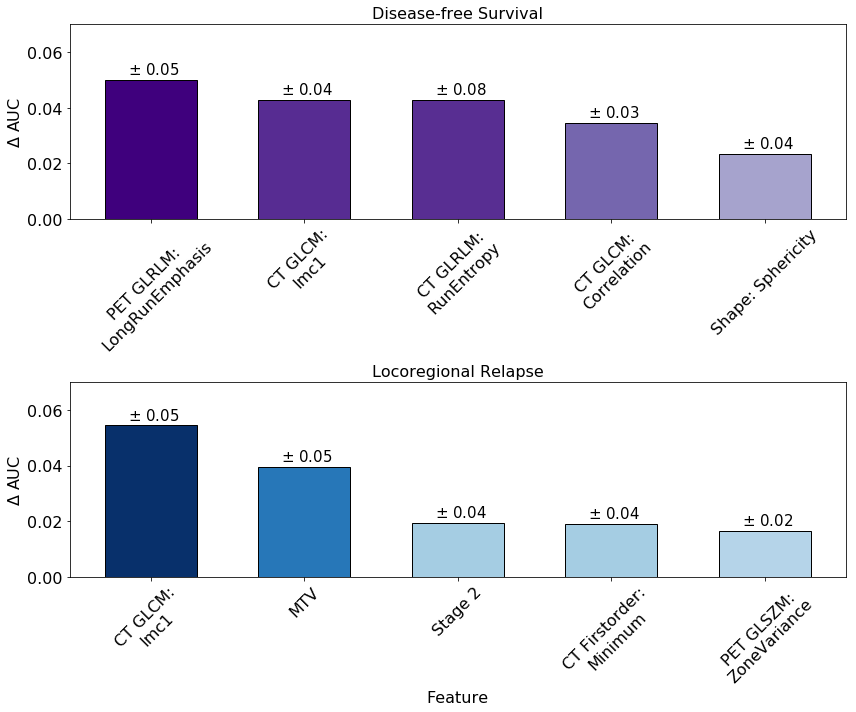

In [58]:
from matplotlib.cm import ScalarMappable


FONTSIZE = 16

# Cmap setup.
cmap1 = plt.cm.get_cmap('Purples')
cmap2 = plt.cm.get_cmap('Blues')
pfs_colors = [bar / max(pfs_avg_top) for bar in pfs_avg_top]
lrc_colors = [bar / max(lrc_avg_top) for bar in lrc_avg_top]

# Compare top features.
fig, axes = plt.subplots(nrows=2, figsize=(12, 10))

axes[0].bar(
    x=range(n_top), height=pfs_avg_top, width=0.6, label='DFS',
    tick_label=prep_feature_names(X_pfs.columns[pfs_top_idx]),
    color=cmap1(pfs_colors), edgecolor='k'
)
axes[0].set_title('Disease-free Survival', fontsize=FONTSIZE)
axes[1].bar(
    x=range(n_top), height=lrc_avg_top, width=0.6, label='LRC',
    tick_label=prep_feature_names(X_lrc.columns[lrc_top_idx]),
    color=cmap2(lrc_colors), edgecolor='k'
)
axes[1].set_title('Locoregional Relapse', fontsize=FONTSIZE)
for axis in axes.ravel():
    axis.yaxis.set_tick_params(labelsize=FONTSIZE)
    axis.xaxis.set_tick_params(labelsize=FONTSIZE, rotation=45)
    axis.set_ylabel(r'$\Delta$ AUC', fontsize=FONTSIZE)
    axis.set_ylim([0, 0.07])

# Set annotations.
for num, patch in enumerate(axes[0].patches):
    # get_width pulls left or right; get_y pushes up or down
    axes[0].text(
        patch.get_x() + 0.15, patch.get_height() + 2e-3, 
        r'$\pm$ {}'.format(np.round(pfs_std_top[num], decimals=2)),
        fontsize=15, color='k'
    )

for num, patch in enumerate(axes[1].patches):
    # get_width pulls left or right; get_y pushes up or down
    axes[1].text(
        patch.get_x() + 0.15, patch.get_height() + 2e-3, 
        r'$\pm$ {}'.format(np.round(lrc_std_top[num], decimals=2)),
        fontsize=15, color='k' #'dimgrey'
    )
    


#axes[0].axhline(y=0.05, c='m', linestyle='--', dashes=(5, 10))
#axes[0].text(3.7, 0.01, 'y={}'.format(0.05))
#axes[1].axhline(y=0.05, c='m', linestyle='--', dashes=(5, 10))
#axes[1].text(-1, 1, 'y={}'.format(0.05))
    
plt.xlabel('Feature', fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig('./../../data/fallback/figures/feature_rankings.png')

In [ ]:
pfs_inid = pfs_avg_top > pfs_std_top
np.array(prep_feature_names(X_pfs.columns[pfs_top_idx]))[pfs_inid]

In [ ]:
lrc_inid = lrc_avg_top > lrc_std_top
np.array(prep_feature_names(X_lrc.columns[lrc_top_idx]))[lrc_inid]

In [57]:
np.linspace(0.0, np.max(pfs_avg_top), 5,)

array([0.        , 0.01251864, 0.02503729, 0.03755593, 0.05007457])

In [53]:
pfs_avg_top

array([0.05007457, 0.04284814, 0.04274496, 0.03444852, 0.02342406])